In [19]:
# global var set
import transformers
# model info, change as needed
batch_size = 16
num_epochs = 16

model_checkpoint = "bert-base-uncased"
# model_checkpoint = "roberta-base"
# model_checkpoint = 'ProsusAI/finbert'
# model_checkpoint= 'distilbert-base-uncased-finetuned-sst-2-english'
metric_name = "f1"
# fileTag = "original-plutchik-v1"

# Convert dataset to suitable format
IMPORTANT: please never run this section again if you have your dataset ready!

In [20]:
import pandas as pd
from pandas import DataFrame

trainDatasetOriginal = pd.read_csv(f'../../data/csv_version/dev/motiv/allcharlinepairs.csv')
testDatasetOriginal = pd.read_csv(f'../../data/csv_version/test/motiv/allcharlinepairs.csv')

In [3]:
trainDatasetOriginal

,storyid,linenum,char,motiveworkerid,context,sentence,action,motivation,maslow,reiss
0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann0,NaN,I began making fish curry for my boyfriend and I.,yes,"[""eat some food""]","[""physiological""]","[""food""]"
1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann1,NaN,I began making fish curry for my boyfriend and I.,yes,"[""to be nice""]","[""love"", ""physiological""]","[""family"", ""romance"", ""food""]"
2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann2,NaN,I began making fish curry for my boyfriend and I.,yes,"[""to satisfy a craving.""]","[""physiological""]","[""food""]"
3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,Boyfriend,none,NaN,I began making fish curry for my boyfriend and I.,no,"[""none""]","[""none""]","[""none""]"
4,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),ann0,I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,"[""to help out""]","[""spiritual growth""]","[""indep""]"
...,...,...,...,...,...,...,...,...,...,...
47542,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,ann0,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,"[""to have collection of shells""]","[""spiritual growth""]","[""curiosity""]"
47543,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,ann1,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,"[""to collect things""]","[""spiritual growth""]","[""curiosity""]"
47544,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,ann2,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,"[""none""]","[""none""]",[]
47545,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Crab,ann0,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,"[""to escape danger""]","[""stability""]","[""tranquility""]"


In [4]:
def findDistribution(inputDF):
    inputDF['reiss'] = [list(i.strip() for i in (x.strip('[').strip(']').strip('\"').strip().replace("\", \"", ", ").split(', '))) for x in inputDF['reiss']]
    # 看一下内容状态
    # count related
    # 每个emotion x 在总字典X[x]中先记录一次freq，
    # 然后同case下的其它情感yi \in {[y1, ..., yn], s.t. yi != x}记录一下freq到Y[x][yi]
    emotionSum = {}
    for dataRow in inputDF['reiss']:
        for emotion in dataRow:
            if emotion in emotionSum:
                relatedEmotionDict = emotionSum.get(emotion)[1];
                for relatedEmotion in dataRow:
                    if relatedEmotion != emotion:
                        relatedEmotionDict[relatedEmotion] = relatedEmotionDict.get(relatedEmotion, 0) + 1
                emotionSum[emotion] = [emotionSum.get(emotion)[0]+1, relatedEmotionDict];
            else:
                emotionSum[emotion] = [1, {}];
    return emotionSum

In [5]:
trainLabelList = list(findDistribution(trainDatasetOriginal).keys())
testLabelList = list(findDistribution(testDatasetOriginal).keys())
trainLabelList.sort()
testLabelList.sort()
print(trainLabelList)
print(testLabelList)

['', 'approval', 'belonging', 'competition', 'contact', 'curiosity', 'family', 'food', 'health', 'honor', 'idealism', 'indep', 'na', 'none', 'order', 'power', 'rest', 'romance', 'savings', 'serenity', 'status', 'tranquility']
['', 'approval', 'belonging', 'competition', 'contact', 'curiosity', 'family', 'food', 'health', 'honor', 'idealism', 'indep', 'na', 'none', 'order', 'power', 'rest', 'romance', 'savings', 'serenity', 'status', 'tranquility']


In [48]:
trainDatasetOriginal = trainDatasetOriginal[trainDatasetOriginal['motiveworkerid'] != 'none'].reset_index(drop=True)
testDatasetOriginal = testDatasetOriginal[testDatasetOriginal['motiveworkerid'] != 'none'].reset_index(drop=True)

In [51]:
import ast
import numpy as np
id2label = ['food', 'family', 'romance', 'indep', 'competition', 
            'approval', 'health', 'contact', 'serenity', 'rest', 
            'order', 'status', 'idealism', 'power', 'curiosity', 
            'honor', 'belonging', 'savings', 'tranquility']

trainDatasetProcessed = pd.DataFrame();
testDatasetProcessed = pd.DataFrame();
trainDatasetProcessed['sentence'] = trainDatasetOriginal['sentence']
testDatasetProcessed['sentence'] = testDatasetOriginal['sentence']
for emotion in id2label:
    trainDatasetProcessed[emotion] = np.where(trainDatasetOriginal['reiss'].str.contains(emotion), 1,0)
    testDatasetProcessed[emotion] = np.where(testDatasetOriginal['reiss'].str.contains(emotion), 1,0)


In [52]:
trainDatasetProcessed.to_csv(f'./dataset/reissDetect-train.csv')
trainDatasetProcessed

,sentence,food,family,romance,indep,competition,approval,health,contact,serenity,rest,order,status,idealism,power,curiosity,honor,belonging,savings,tranquility
0,I began making fish curry for my boyfriend and I.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,I began making fish curry for my boyfriend and I.,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,I began making fish curry for my boyfriend and I.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,I decided not to read a recipe since I've made...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,I decided not to read a recipe since I've made...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36115,A crab was inside the shell pinching his leg.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
36116,A crab was inside the shell pinching his leg.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
36117,A crab was inside the shell pinching his leg.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36118,A crab was inside the shell pinching his leg.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [53]:
testDatasetProcessed.to_csv(f'./dataset/reissDetect-test.csv')
testDatasetProcessed

,sentence,food,family,romance,indep,competition,approval,health,contact,serenity,rest,order,status,idealism,power,curiosity,honor,belonging,savings,tranquility
0,A cook was carrying an armful of oranged in th...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A cook was carrying an armful of oranged in th...,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
2,A cook was carrying an armful of oranged in th...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,He dropped one on the floor by accident.,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,He dropped one on the floor by accident.,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29397,She had been dieting for weeks and was starving.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29398,"After she stuffed herself, she regretted it.",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29399,"After she stuffed herself, she regretted it.",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29400,Rosemary swore to eat healthier tomorrow.,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Start convert and train

In [54]:
from datasets import load_dataset, load_metric
dataset = load_dataset('csv', data_files={'train': f'./dataset/reissDetect-train.csv', 
                                           'test': f'./dataset/reissDetect-test.csv'})
dataset

Using custom data configuration default-cfc7cf41c6719c98


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\JAM_0\.cache\huggingface\datasets\csv\default-cfc7cf41c6719c98\0.0.0\9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'sentence', 'food', 'family', 'romance', 'indep', 'competition', 'approval', 'health', 'contact', 'serenity', 'rest', 'order', 'status', 'idealism', 'power', 'curiosity', 'honor', 'belonging', 'savings', 'tranquility'],
        num_rows: 36120
    })
    test: Dataset({
        features: ['Unnamed: 0', 'sentence', 'food', 'family', 'romance', 'indep', 'competition', 'approval', 'health', 'contact', 'serenity', 'rest', 'order', 'status', 'idealism', 'power', 'curiosity', 'honor', 'belonging', 'savings', 'tranquility'],
        num_rows: 29402
    })
})

Let's check the first example of the training split:

In [55]:
example = dataset['train'][0]
example

{'Unnamed: 0': 0,
 'sentence': 'I began making fish curry for my boyfriend and I.',
 'food': 1,
 'family': 0,
 'romance': 0,
 'indep': 0,
 'competition': 0,
 'approval': 0,
 'health': 0,
 'contact': 0,
 'serenity': 0,
 'rest': 0,
 'order': 0,
 'status': 0,
 'idealism': 0,
 'power': 0,
 'curiosity': 0,
 'honor': 0,
 'belonging': 0,
 'savings': 0,
 'tranquility': 0}

The dataset consists of tweets, labeled with one or more emotions. 

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [56]:
labels = [label for label in dataset['train'].features.keys() if label not in ['Unnamed: 0', 'sentence']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['food',
 'family',
 'romance',
 'indep',
 'competition',
 'approval',
 'health',
 'contact',
 'serenity',
 'rest',
 'order',
 'status',
 'idealism',
 'power',
 'curiosity',
 'honor',
 'belonging',
 'savings',
 'tranquility']

## Preprocess data

As models like BERT don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

What's a bit tricky is that we also need to provide labels to the model. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). Also important: this should be a tensor of floats rather than integers, otherwise PyTorch' `BCEWithLogitsLoss` (which the model will use) will complain, as explained [here](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3).

In [57]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_data(examples):
    # take a batch of texts
    text = examples["sentence"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
    encoding["labels"] = labels_matrix.tolist()
    return encoding

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\JAM_0/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

In [58]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

In [59]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['attention_mask', 'input_ids', 'labels', 'token_type_ids'])


In [60]:
tokenizer.decode(example['input_ids'])

'[CLS] i began making fish curry for my boyfriend and i. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [61]:
example['labels']

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [62]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['food']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html). 

In [63]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

In [64]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id, 
                                                           ignore_mismatched_sizes=True)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\JAM_0/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "food",
    "1": "family",
    "2": "romance",
    "3": "indep",
    "4": "competition",
    "5": "approval",
    "6": "health",
    "7": "contact",
    "8": "serenity",
    "9": "rest",
    "10": "order",
    "11": "status",
    "12": "idealism",
    "13": "power",
    "14": "curiosity",
    "15": "honor",
    "16": "belonging",
    "17": "savings",
    "18": "tranquility"
  },
  "initializer_

## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things: 

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [65]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    # learning_rate=9e-7,
    learning_rate=6e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

In [66]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from sklearn import metrics
import torch
import matplotlib.pyplot as plt

validationInfo = []
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')    
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    validationInfo.append([y_true, probs])
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [67]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [68]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  1045,  2211,  2437,  3869, 15478,  2005,  2026,  6898,  1998,
         1045,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [69]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7318, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.2166, -0.0400,  0.6630, -0.0709, -0.0116, -0.0044, -0.0834, -0.0217,
          0.2670,  0.1229,  0.6411,  0.6647, -0.3908,  0.3979, -0.5342, -0.2744,
         -0.2512,  0.0444,  0.0279]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Let's start training!

In [70]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [71]:
trainer.train()

C:\Python\miniconda3\envs\pytorchenvwithdatasci\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 36120
  Num Epochs = 16
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 36128


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.220100,0.216579,0.050353,0.512620,0.224543
2,0.206000,0.207193,0.146166,0.539604,0.252160
3,0.198700,0.205030,0.170993,0.547478,0.261921
4,0.191600,0.205892,0.191849,0.554551,0.265322
5,0.186300,0.205990,0.197917,0.556713,0.265492
6,0.179400,0.207626,0.201103,0.557913,0.264268
7,0.178000,0.207898,0.211675,0.561719,0.268417
8,0.174300,0.209537,0.221046,0.565436,0.267261
9,0.172200,0.210650,0.218243,0.564363,0.266444
10,0.168900,0.211150,0.218024,0.564388,0.264200


***** Running Evaluation *****
  Num examples = 29402
  Batch size = 16
Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-2258
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-2258\config.json
Model weights saved in bert-finetuned-sem_eval-english\checkpoint-2258\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-2258\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-2258\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 29402
  Batch size = 16
Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-4516
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-4516\config.json
Model weights saved in bert-finetuned-sem_eval-english\checkpoint-4516\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-4516\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-englis

TrainOutput(global_step=36128, training_loss=0.17976512493973185, metrics={'train_runtime': 6055.3014, 'train_samples_per_second': 95.44, 'train_steps_per_second': 5.966, 'total_flos': 3.802008763219968e+16, 'train_loss': 0.17976512493973185, 'epoch': 16.0})

# ROC curve generate

In [79]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import pandas as pd

y_test = validationInfo[pd.DataFrame(trainer.state.log_history)['eval_accuracy'].dropna().reset_index(drop=True).idxmax()][0]
y_score = validationInfo[pd.DataFrame(trainer.state.log_history)['eval_accuracy'].dropna().reset_index(drop=True).idxmax()][1]
plt.rcParams['figure.figsize'] = (12.0, 11.0)
currentAcc = round(pd.DataFrame(trainer.state.log_history)['eval_accuracy'].dropna().reset_index(drop=True).max() * 100, 2)
n_classes = 8

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for index, label in enumerate(id2label.values()):
    fpr[label], tpr[label], _ = roc_curve(y_test[:, index], y_score[:, index])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

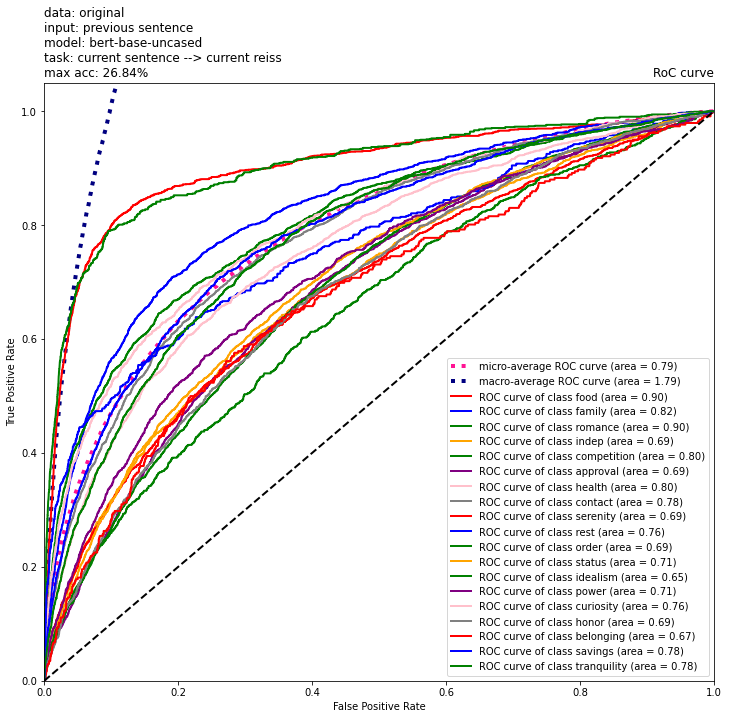

In [80]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[label] for index, label in enumerate(id2label.values())]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for index, label in enumerate(id2label.values()):
    mean_tpr += np.interp(all_fpr, fpr[label], tpr[label])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["red", "blue", "green", "orange", "green", "purple", "pink", "grey"])
for i, color in zip([label for index, label in enumerate(id2label.values())], colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"RoC curve", loc = 'right')
plt.title(f"data: original \
          \ninput: previous sentence\
          \nmodel: {model_checkpoint}\
          \ntask: current sentence --> current reiss\
          \nmax acc: {currentAcc}%", loc='left')
plt.legend(loc="lower right")
plt.show()

In [74]:
import pandas as pd
dataLog = pd.DataFrame(trainer.state.log_history)
dataLog.to_csv(f'./trainingMetric/TI-{model_checkpoint}.csv')

## Inference

Let's test the model on a new sentence:

In [43]:
text = "I'm sad and want to die"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [44]:
logits = outputs.logits
logits.shape

torch.Size([1, 8])

To turn them into actual predicted labels, we first apply a sigmoid function independently to every score, such that every score is turned into a number between 0 and 1, that can be interpreted as a "probability" for how certain the model is that a given class belongs to the input text.

Next, we use a threshold (typically, 0.5) to turn every probability into either a 1 (which means, we predict the label for the given example) or a 0 (which means, we don't predict the label for the given example).

In [45]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['joy', 'trust', 'anticipation']
